# Telco Customer Churn Analysis using IV and WOE

One of the most important metrics for a business to evaluate is customer churn. It measures number of customers who stopped using the company's product or service during a certain time frame. It's crucial to keep track of this metric since it costs more to acquire new customers that it does to retain existing customers. Being aware what factors influence customers' retention and how to distinguish clients who are more likely to churn is a key to success and enables businesses to take appropriate actions.

Telco dataset contains data about customer churn in a telephone service company. It includes information about customers who left within the last month, services that each customer has signed up for, customer account information and demographic information.

The goal of this analysis is to explore factors that influence customer churn and to define churner profile.

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

## Data Overview

The dataset contains 7043 records representing company customers. Churn column indicates who opt out of services within the last month. There are 20 explanatory variables - both categorical and continuous features.

In the analysis variables of numeric type (int, float) were recognized as continuous features, while string variables were treated as categorical features.

Services as: online security, tech support, online backup, streaming TV, streaming movies and device protection are dedicated only to customers with internet service. Because of that the analysis is divided into 2 parts:
* the analysis of features referring to all customers (excluding the above features)
* the analysis of customers who use internet service (only the above features).

In [3]:
df = pd.read_csv('data/telco_churn.csv', na_values=[' '])

In [4]:
df.columns = [c[0].lower() + c[1:] for c in df.columns]
df['label'] = df['churn'].map({'Yes': 0, 'No': 1})
df['seniorCitizen'] = df['seniorCitizen'].map({1: 'Yes', 0: 'No'})
df.drop(['customerID', 'churn'], axis=1, inplace=True)

In [5]:
df.sample(5)

,gender,seniorCitizen,partner,dependents,tenure,phoneService,multipleLines,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies,contract,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,label
6523,Female,No,No,No,15,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Mailed check,45.90,693.45,1
6628,Female,No,No,No,7,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,One year,Yes,Mailed check,94.05,633.45,1
3011,Female,No,Yes,Yes,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.75,210.65,1
4953,Female,No,No,No,29,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.40,554.25,1
1326,Female,No,Yes,Yes,43,No,No phone service,DSL,Yes,Yes,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),51.25,"2,151.60",1


In [6]:
feats_dict = {}
black_list = ['onlineSecurity', 'techSupport', 'onlineBackup', 'streamingTV', 'streamingMovies', 'deviceProtection']

for col in [c for c in df.columns if c not in black_list and c != 'label']:
    if is_numeric_dtype(df[col]):
        feats_dict[col] = ContinuousFeature(df, col)
    else:
        feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

## Information Value and Weight of Evidence

Attribute relevance analysis evaluates attribute values' impact on target variable. It helps in recognizing the most important variables which has greatest impact on target variable and understanding relations and logic between the most important predictors and the target variable.

Information value (IV) and weight of evidence (WOE) are simple and powerful techniques of conducting attribute relevance analysis. They provide a great framework for exploratory analysis and have been used extensively in the credit risk world for several decades.

**Information value**
>Information Value provides a measure of how well a variable X is able to distinguish between a binary response (e.g. "good" versus "bad") in some target variable Y. The idea is if a variable X has a low Information Value, it may not do a sufficient job of classifying the target variable, and hence is removed as an explanatory variable.

**Weight of evidence**
>The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

**IV values interpretation**

| Information value        | Predictive power           |
| ------------- |:-------------:|
| < 0.02      | useless for prediction |
| 0.02 - 0.1      | weak predictor      |
| 0.1 - 0.3 | medium predictor      |
| 0.3 - 0.5 | strong predictor      |
| > 0.5 | suspicious or too good      |

In [7]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()

## Information value analysis

Customers who churned are labeled with value 0 ('bad' customers) and those who retained with value 1 ('good' customers). It implies that positive WOE means higher probability of retention and negative WOE - higher probability of churn.

As mentioned before, the analysis was divided into 2 parts: analysis of all customers and analysis of only customers with internet service. It reveals some interesting relations:

**Suspicious predictors**

This group contains: contract, tenure and internet service. It shows that relation between values of those features and churn is very strong - so strong that it should be examined carefully. It may suggest that there is some error in the data or that explanatory and explained variables are not independent.

Analysis of 'contract' feature shows that WOE for month-to-month contracts is negative while it's very high for two year contracts. It can be explained by the fact that customers with shorter contract have much more 'churn moments' (every month they need to renew their service) than customers with long-term contracts thus their churn rate is much higher.

**Strong predictors**

Fortunately, this group of features is quite big. It contains: payment method, total charges, online security and tech support. They show strong relation between value of the feature and churn. They can be successfully used to predict churn of the customer.

Analysis of total charges shows that customers who have already spent more than \\$678 are less likely to churn. To fully understand this relation it's good to notice that total charges is the resultant of monthly charge and the tenure. Monthly charges variable tells us that users who pay \\$18 - \\$50 monthly are less likely to churn and the risk of churn increases with the increase of monthly fee. In this case, although total charges feature has higher IV, it seems more actionable to use monthly charges and tenure variables separately.

In [8]:
ar.analyze(feats, iv, interpretation=True)

C:\Users\klaud\Anaconda3\envs\master\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,iv,iv_interpretation
contract,1.24,suspicious
tenure,0.78,suspicious
internetService,0.62,suspicious
paymentMethod,0.46,strong
totalCharges,0.32,strong
paperlessBilling,0.20,medium
monthlyCharges,0.17,medium
dependents,0.16,medium
partner,0.12,medium
seniorCitizen,0.11,medium


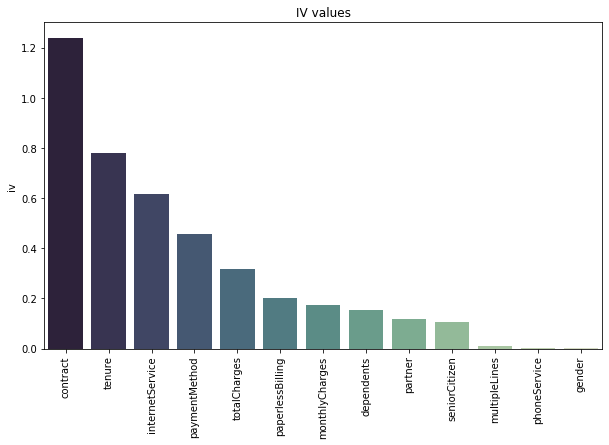

In [9]:
ar.draw_iv(feats, iv)

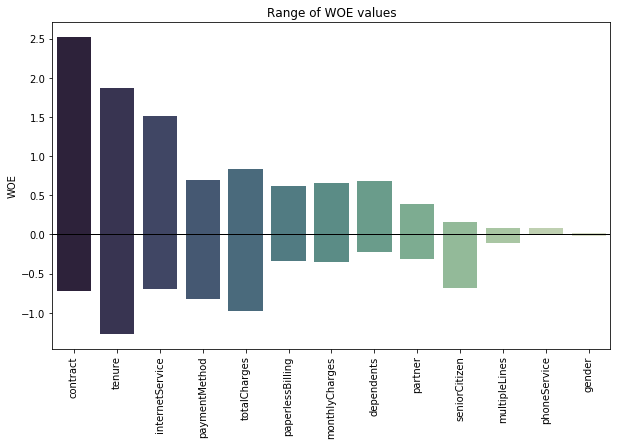

In [10]:
ar.draw_woe_extremes(feats, iv)

In [11]:
feats_dict_black = {}
df_black = df[df['internetService']!='No']
for b in black_list:
    feats_dict_black[b] = CategoricalFeature(df_black, b)

feats_black = list(feats_dict_black.values())

In [12]:
ar.analyze(feats_black, iv, interpretation=True)

C:\Users\klaud\Documents\git\woe-and-iv\Features.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lite['bin'] = df_lite[self.feature].fillna('MISSING')


,iv,iv_interpretation
onlineSecurity,0.42,strong
techSupport,0.39,strong
onlineBackup,0.18,medium
deviceProtection,0.15,medium
streamingMovies,0.01,useless
streamingTV,0.01,useless


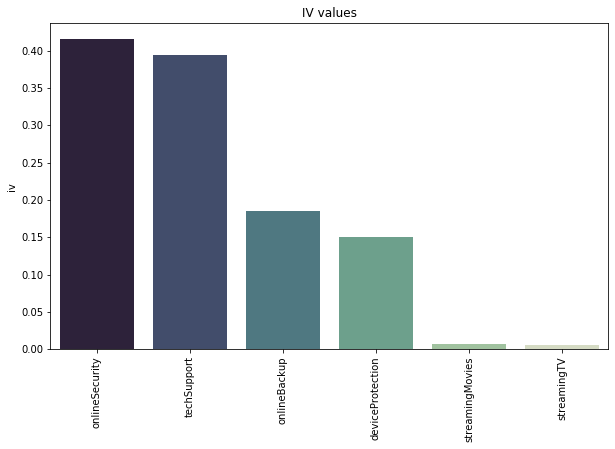

In [13]:
ar.draw_iv(feats_black, iv)

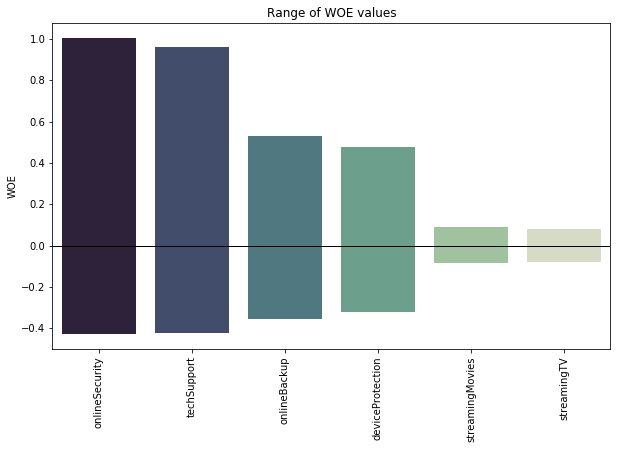

In [14]:
ar.draw_woe_extremes(feats_black, iv)

## Weight of evidence analysis

Detailed examination of WOE provides interesting insights and shows some possible issues in the services offered by the company.

**Tenure vs total charges**

As mentioned before, those two features show very similar behaviour - and it is totally logical since total charges = tenure * monthly charges. It's good to have it in mind and focus more on monthly charges variable instead of total charges.

**Internet service**

Among the customers there are those who use DSL network, Fiber optic network or don't use the internet service. It's interesting to see that customers using Fiber optic are much more likely to churn - it may suggest some problems with the service.

**Payment method**

The company offers four different payment methods: bank transfer, credit card, electronic check and mailed check. The analysis shows that users who pay with electronic check are more likely to churn. In order to understand this relation it's good to check which payment methods are recurring and what are the possible issues that customers have while using electronic check.

**Additional Internet services**

The analysis of customers using Internet service shows that those who use additional services like: online security, tech support and online backup are more likely to retain.

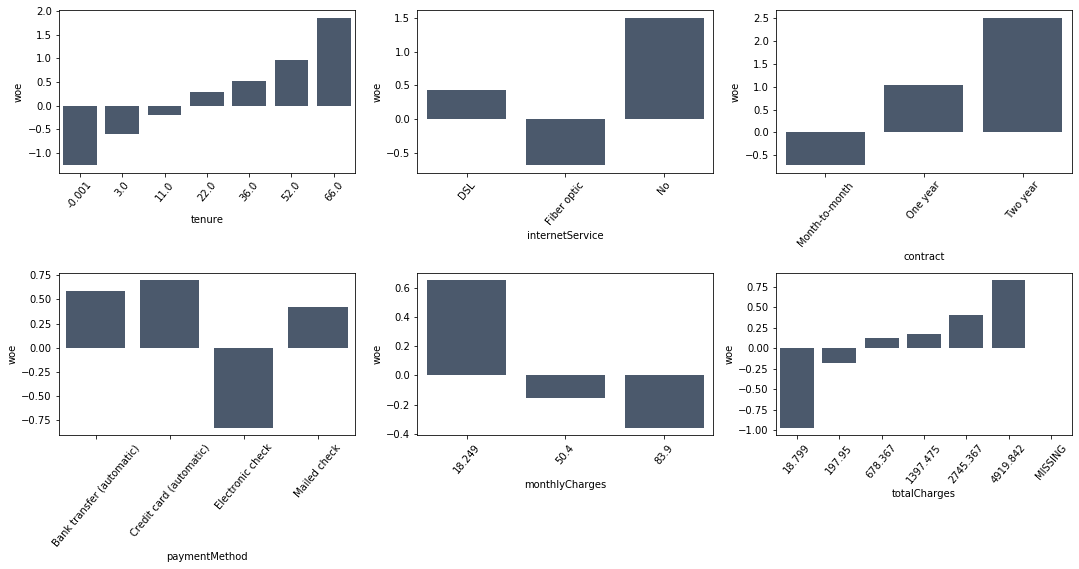

In [15]:
f_draw = ['contract', 'tenure', 'internetService', 'paymentMethod', 'totalCharges', 'monthlyCharges', 'charges']
feats_draw = [v for k, v in feats_dict.items() if k in f_draw]
ar.draw_woe_multiplot(feats_draw, iv)

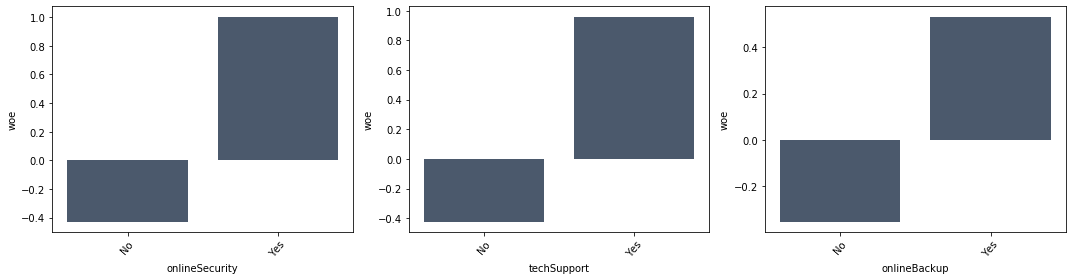

In [16]:
f_black_draw = ['onlineSecurity', 'techSupport', 'onlineBackup']
feats_black_draw = [v for k, v in feats_dict_black.items() if k in f_black_draw]
ar.draw_woe_multiplot(feats_black_draw, iv)

## Churner profile

Let's answer the question: which of the company's customers are thinking about resigning from the services?

According to the analysis this is the typical churners profile:
* **Tenure:** has been using the services for less than 3 months
* **Contract:** has month-to-month contract
* **Monthly charges:** pays more than \\$50 monthly
* **Internet service:** Fiber optic
* **Payment method:** electronic check
* **Additional Internet services:** doesn't use online security and tech support

## Action points

Sooo... the analysis revealed interesting relations and now, what's next?

The first step is to make Customer Support Team, Product Owners, Marketing Managers familiar with the results of the analysis. There are some actions that should be taken by them in order to increase the customers' retention and improve the growth of the company.

There is a list of possible action points:
* maintain the personal contact with customers with more expensive plans to make sure that they are satisfied with the service
* allow only recurring payment methods for month-to-month plan to make sure that customers don't forget about the payment
* send email notifications about upcoming payments
* in the first 3 months of service offer special deal for customers - if they pay in advance, they will get a discount
* evaluate Fiber Optic network and electronic check payment method - investigate what is the reason of higher churn and resolve the issue

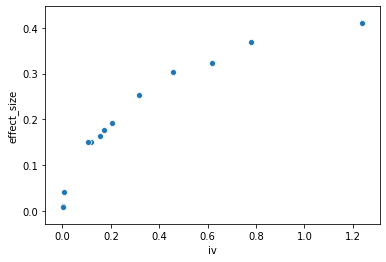

In [62]:
o = ar.analyze(feats, iv, s, interpretation=True)
sns.scatterplot(x='iv', y='effect_size', data=o)

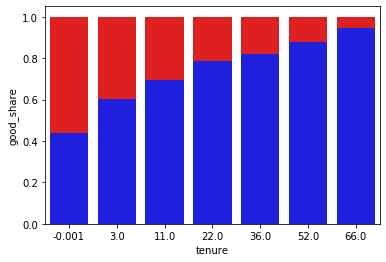

In [63]:
x = iv.group_by_feature(feats_dict['tenure'])
x['total'] = 1
x['good_share'] = x['good'] / x['count']
sns.barplot(x='tenure', y='total', data=x, color='red')
sns.barplot(x='tenure', y='good_share', data=x, color='blue')

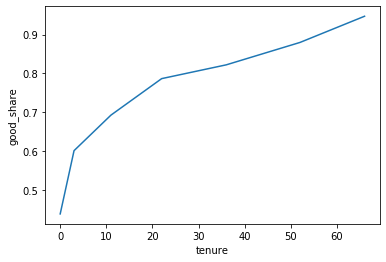

In [64]:
sns.lineplot(x='tenure', y='good_share', data=x)

In [66]:
def evaluate_feature(feature, feats_group=feats_dict):
    iv.draw_woe(feats_group[feature])
    iv.print_iv(feats_group[feature])
    print('')
    s.print_chi(feats_group[feature])

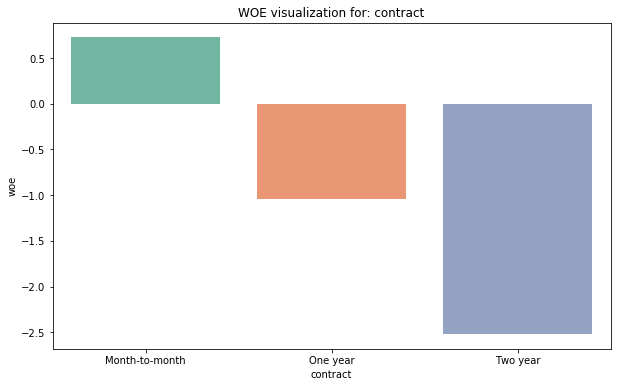

Information value: 1.24
Contract is a suspicious predictor

P-value: 0.00
Effect size: 0.41
Contract is a strong predictor


In [206]:
evaluate_feature('contract')

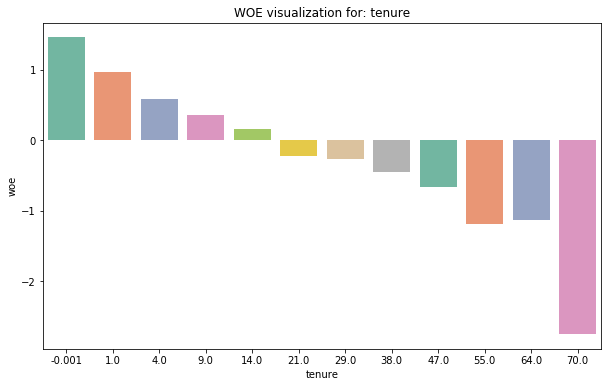

Information value: 0.85
Tenure is a suspicious predictor

P-value: 0.00
Effect size: 0.38
Tenure is a medium predictor


In [207]:
evaluate_feature('tenure')

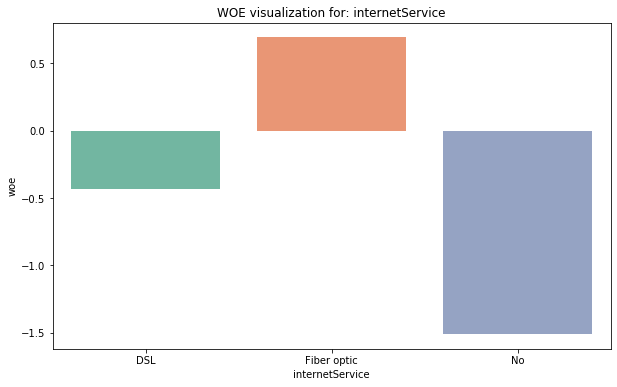

Information value: 0.62
Internetservice is a suspicious predictor

P-value: 0.00
Effect size: 0.32
Internetservice is a medium predictor


In [208]:
evaluate_feature('internetService')

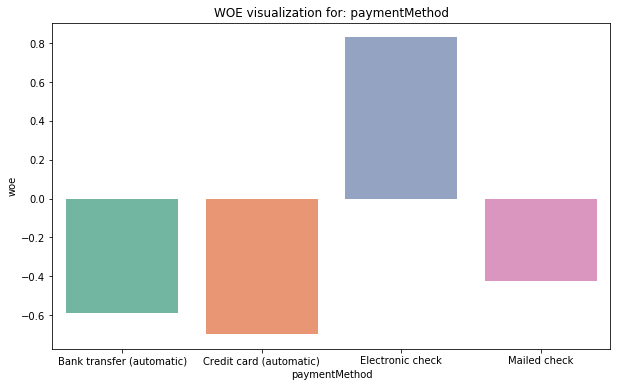

Information value: 0.46
Paymentmethod is a strong predictor

P-value: 0.00
Effect size: 0.30
Paymentmethod is a medium predictor


In [209]:
evaluate_feature('paymentMethod')

In [210]:
iv.group_by_feature(feats_dict['paymentMethod'])

,paymentMethod,count,good,bad
0,Bank transfer (automatic),1544,258,1286
1,Credit card (automatic),1522,232,1290
2,Electronic check,2365,1071,1294
3,Mailed check,1612,308,1304


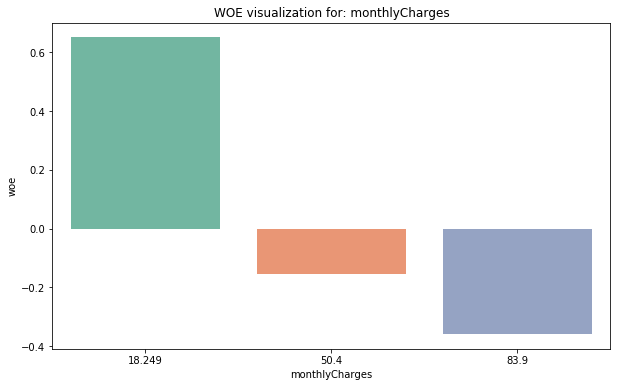

Information value: 0.17
Monthlycharges is a medium predictor

P-value: 0.00
Effect size: 0.18
Monthlycharges is a weak predictor


In [67]:
evaluate_feature('monthlyCharges')

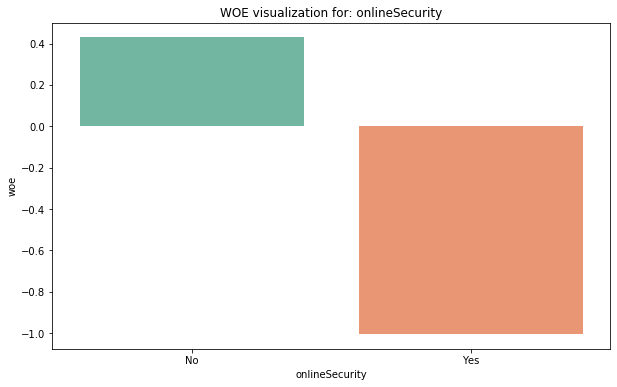

Information value: 0.42
Onlinesecurity is a strong predictor

P-value: 0.00
Effect size: 0.28
Onlinesecurity is a medium predictor


In [212]:
evaluate_feature('onlineSecurity', feats_group=feats_dict_black)

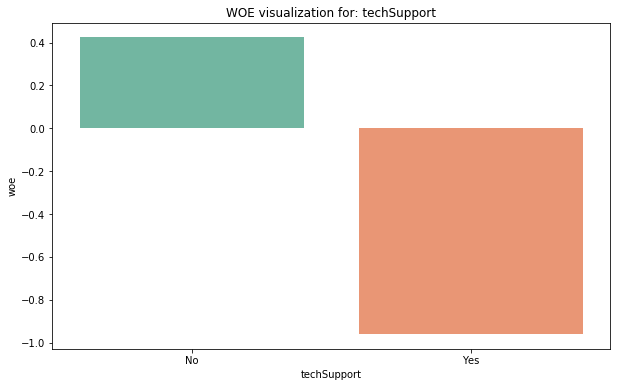

Information value: 0.39
Techsupport is a strong predictor

P-value: 0.00
Effect size: 0.27
Techsupport is a medium predictor


In [213]:
evaluate_feature('techSupport', feats_group=feats_dict_black)

* customerIDCustomer ID
* genderWhether the customer is a male or a female
* SeniorCitizenWhether the customer is a senior citizen or not (1, 0)
* PartnerWhether the customer has a partner or not (Yes, No)
* DependentsWhether the customer has dependents or not (Yes, No)
* tenureNumber of months the customer has stayed with the company
* PhoneServiceWhether the customer has a phone service or not (Yes, No)
* MultipleLinesWhether the customer has multiple lines or not (Yes, No, No phone service)
* InternetServiceCustomer’s internet service provider (DSL, Fiber optic, No)
* OnlineSecurityWhether the customer has online security or not (Yes, No, No internet service)
* OnlineBackupWhether the customer has online backup or not (Yes, No, No internet service)
* DeviceProtectionWhether the customer has device protection or not (Yes, No, No internet service)
* TechSupportWhether the customer has tech support or not (Yes, No, No internet service)
* StreamingTVWhether the customer has streaming TV or not (Yes, No, No internet service)
* StreamingMoviesWhether the customer has streaming movies or not (Yes, No, No internet service)
* ContractThe contract term of the customer (Month-to-month, One year, Two year)
* PaperlessBillingWhether the customer has paperless billing or not (Yes, No)
* PaymentMethodThe customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyChargesThe amount charged to the customer monthly
* TotalChargesThe total amount charged to the customer
* ChurnWhether the customer churned or not (Yes or No)

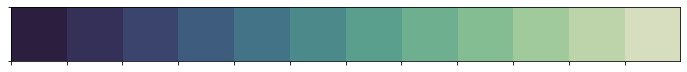

In [17]:
sns.palplot(sns.cubehelix_palette(12, start=.5, rot=-.75, reverse=True))